# Portland Housing Prices — Full EDA & Modeling Notebook
This notebook performs complete exploratory data analysis and builds forecasting models for Portland, OR median monthly home prices (2012–2025).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set(style="whitegrid")

df = pd.read_csv("portland, or prices 2012-2022.csv")

df.head()

,Region,Month of Period End,Measure Names,Measure Values
0,"Portland, OR",May 2022,Median Sale Price,577000.0
1,"Portland, OR",July 2022,Median Sale Price,560000.0
2,"Portland, OR",June 2025,Median Sale Price,559900.0
3,"Portland, OR",June 2022,Median Sale Price,555000.0
4,"Portland, OR",April 2022,Median Sale Price,551000.0


## Data Cleaning

In [2]:

df = df.rename(columns={
    "Month of Period End": "Date",
    "Measure Values": "median_price"
})

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df = df[["Date","median_price"]]
df.head()

/tmp/ipykernel_5981/464762211.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,median_price
0,2012-01-01,230000.0
1,2012-02-01,228500.0
2,2012-03-01,239000.0
3,2012-04-01,239500.0
4,2012-05-01,260000.0


## Basic Time Series Plot

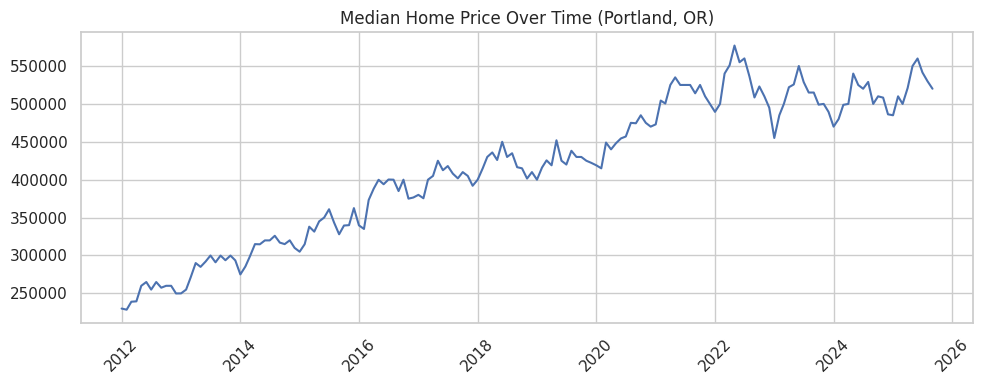

In [3]:

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["median_price"])
plt.title("Median Home Price Over Time (Portland, OR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Feature Engineering

In [4]:

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

df["lag1"] = df["median_price"].shift(1)
df["lag3"] = df["median_price"].shift(3)
df["lag12"] = df["median_price"].shift(12)

df["roll3"] = df["median_price"].rolling(3).mean()
df["roll12"] = df["median_price"].rolling(12).mean()

df["pct_change"] = df["median_price"].pct_change()*100

df_fe = df.dropna().reset_index(drop=True)
df_fe.head()

,Date,median_price,Year,Month,lag1,lag3,lag12,roll3,roll12,pct_change
0,2013-01-01,250000.0,2013,1,249900.0,260000.0,230000.0,253300.000000,252450.000000,0.040016
1,2013-02-01,255000.0,2013,2,250000.0,260000.0,228500.0,251633.333333,254658.333333,2.000000
2,2013-03-01,271000.0,2013,3,255000.0,249900.0,239000.0,258666.666667,257325.000000,6.274510
3,2013-04-01,290000.0,2013,4,271000.0,250000.0,239500.0,272000.000000,261533.333333,7.011070
4,2013-05-01,285000.0,2013,5,290000.0,255000.0,260000.0,282000.000000,263616.666667,-1.724138


## Correlation Heatmap

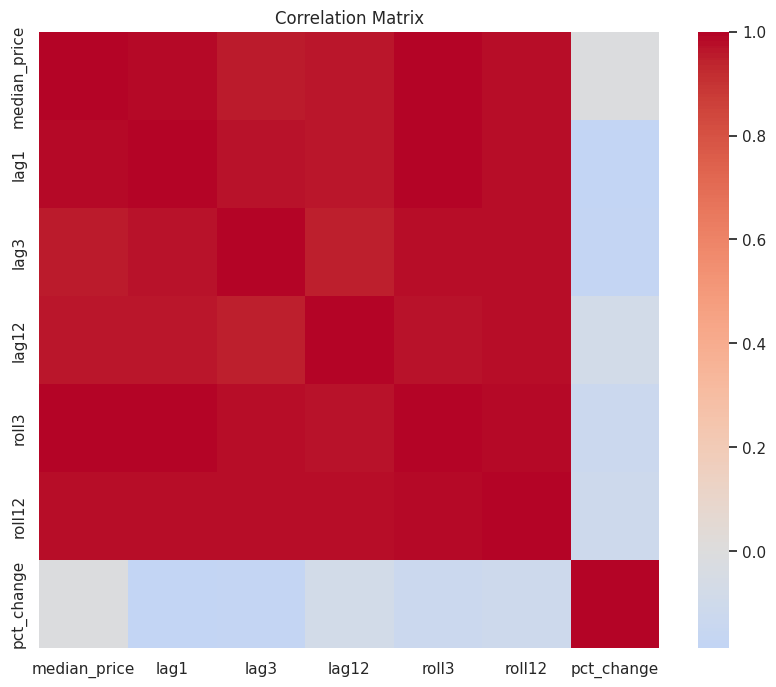

In [5]:

numeric_cols = df_fe.select_dtypes(include=['float64','int64']).columns.tolist()
corr = df_fe[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()


## Train-Test Split (Time Aware)

In [6]:

split_year = 2020
train = df_fe[df_fe["Year"] < split_year]
test = df_fe[df_fe["Year"] >= split_year]

feature_cols = ["Year","Month","lag1","lag3","lag12","roll3","roll12"]
X_train = train[feature_cols]
y_train = train["median_price"]

X_test = test[feature_cols]
y_test = test["median_price"]

X_train.shape, X_test.shape

((84, 7), (69, 7))

## Baseline Model

In [7]:

y_pred_base = X_test["lag1"]
baseline_mae = mean_absolute_error(y_test, y_pred_base)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
baseline_mae, baseline_rmse

(14131.159420289856, np.float64(17476.80590822085))

## Linear Regression Model

In [8]:

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

lr_mae, lr_rmse, lr_r2

(8238.153628813952, np.float64(10597.037321374384), 0.8960803519268561)

## Random Forest Model

In [9]:

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_rmse, rf_r2

(68510.2576811594, np.float64(75105.24330213862), -4.219984990974164)

## Gradient Boosting Model

In [10]:

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)

gb_mae, gb_rmse, gb_r2

(57334.07641373704, np.float64(63777.1207389568), -2.7640775047750616)

## Model Comparison Summary

In [11]:

results = pd.DataFrame({
    "Model":["Baseline","Linear Regression","Random Forest","Gradient Boosting"],
    "MAE":[baseline_mae, lr_mae, rf_mae, gb_mae],
    "RMSE":[baseline_rmse, lr_rmse, rf_rmse, gb_rmse],
    "R2":[None, lr_r2, rf_r2, gb_r2]
})
results

,Model,MAE,RMSE,R2
0,Baseline,14131.159420,17476.805908,NaN
1,Linear Regression,8238.153629,10597.037321,0.896080
2,Random Forest,68510.257681,75105.243302,-4.219985
3,Gradient Boosting,57334.076414,63777.120739,-2.764078


### Baseline Model Visualizations

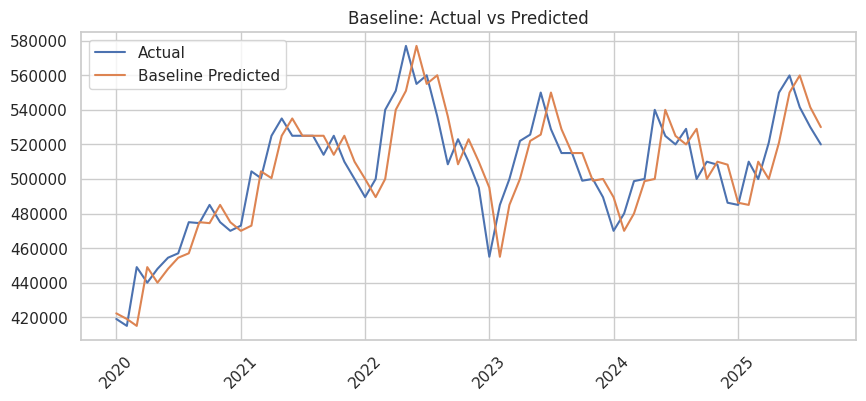

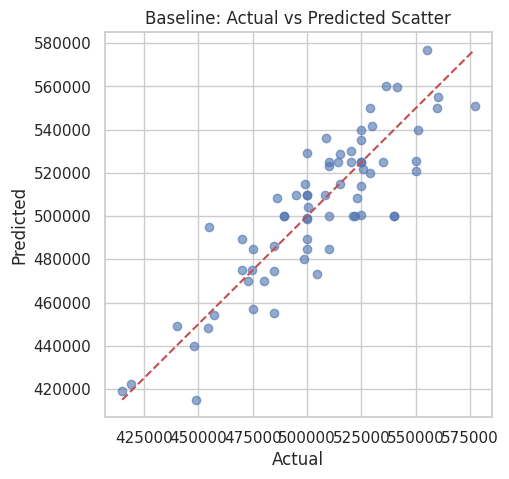

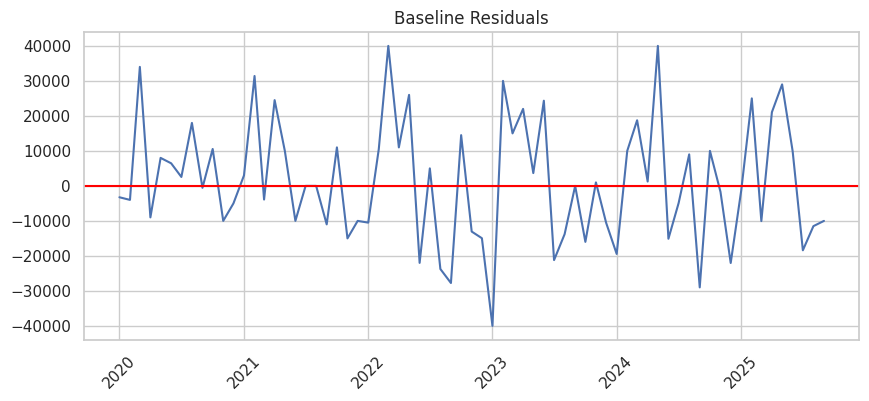

In [12]:

# Actual vs Predicted
plt.figure(figsize=(10,4))
plt.plot(test["Date"], y_test, label="Actual")
plt.plot(test["Date"], y_pred_base, label="Baseline Predicted")
plt.legend(); plt.xticks(rotation=45); plt.title("Baseline: Actual vs Predicted")
plt.show()

# Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_base, alpha=0.6)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Baseline: Actual vs Predicted Scatter")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.show()

# Residual plot
res = y_test - y_pred_base
plt.figure(figsize=(10,4))
plt.plot(test["Date"], res)
plt.title("Baseline Residuals"); plt.xticks(rotation=45)
plt.axhline(0, color='red')
plt.show()


### Linear Regression Visualizations

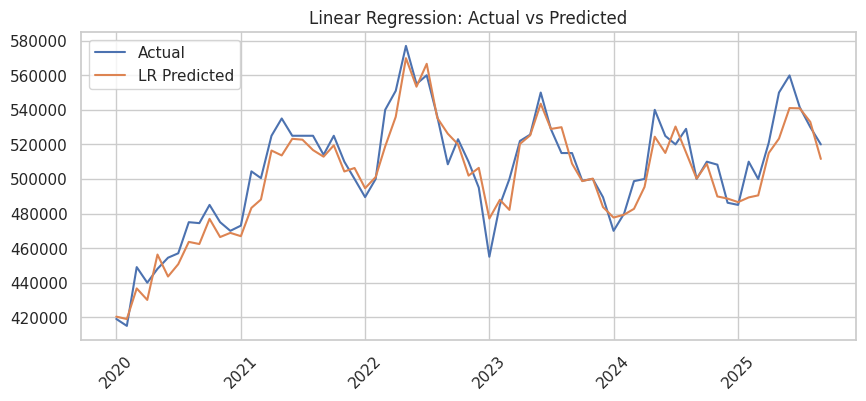

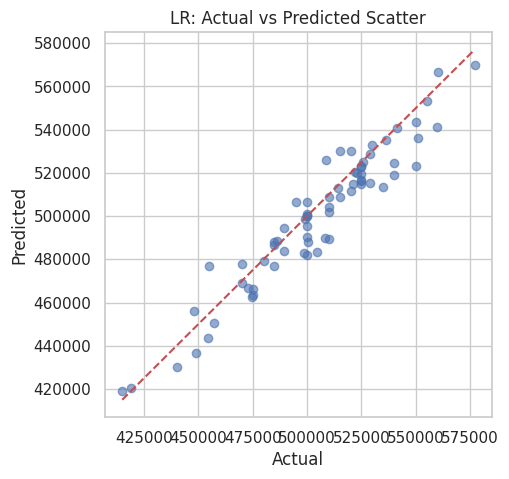

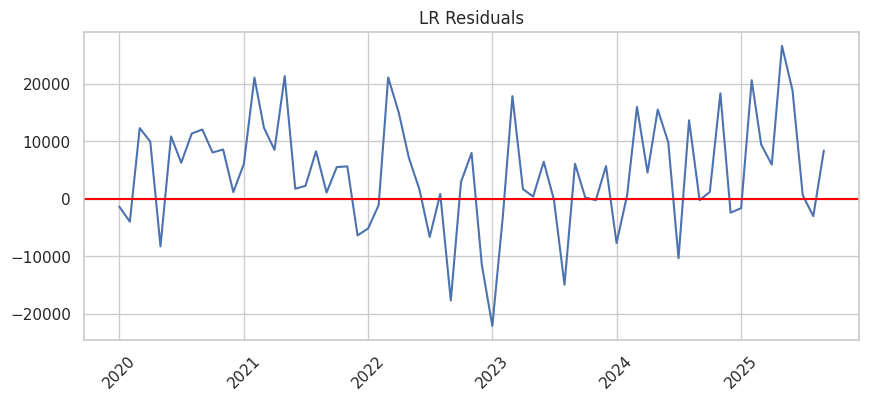

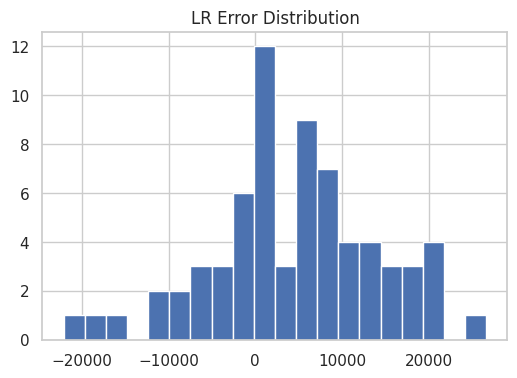

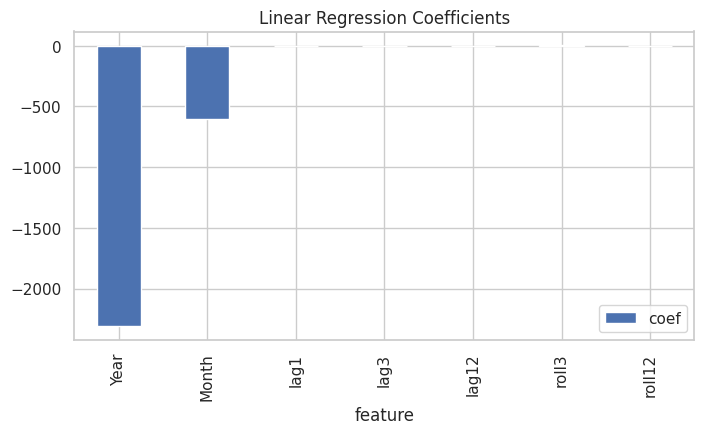

In [13]:

# Line plot
plt.figure(figsize=(10,4))
plt.plot(test["Date"], y_test, label="Actual")
plt.plot(test["Date"], y_pred_lr, label="LR Predicted")
plt.legend(); plt.xticks(rotation=45); plt.title("Linear Regression: Actual vs Predicted")
plt.show()

# Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("LR: Actual vs Predicted Scatter")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.show()

# Residual plot
res_lr = y_test - y_pred_lr
plt.figure(figsize=(10,4))
plt.plot(test["Date"], res_lr)
plt.title("LR Residuals"); plt.xticks(rotation=45)
plt.axhline(0, color='red')
plt.show()

# Error histogram
plt.figure(figsize=(6,4))
plt.hist(res_lr, bins=20)
plt.title("LR Error Distribution")
plt.show()

# Coefficient bar chart
coef_df = pd.DataFrame({"feature": feature_cols, "coef": lr.coef_})
coef_df.plot.bar(x="feature", y="coef", figsize=(8,4), title="Linear Regression Coefficients")
plt.show()


### Random Forest Visualizations

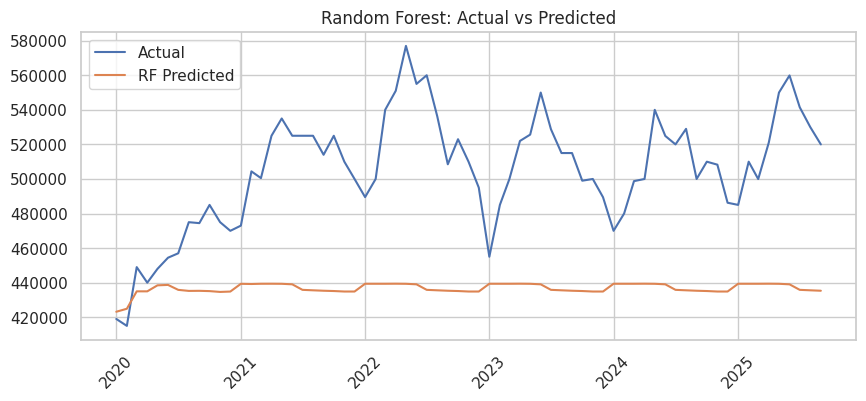

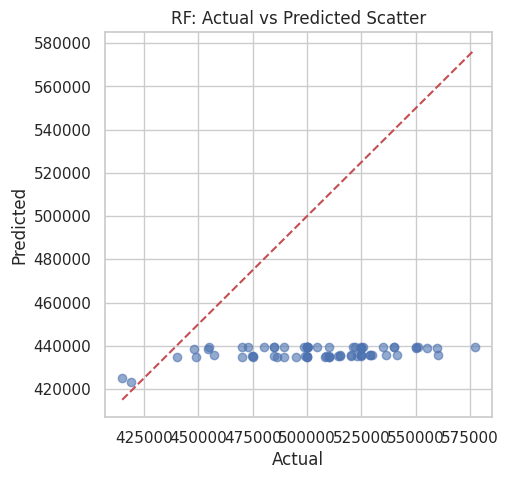

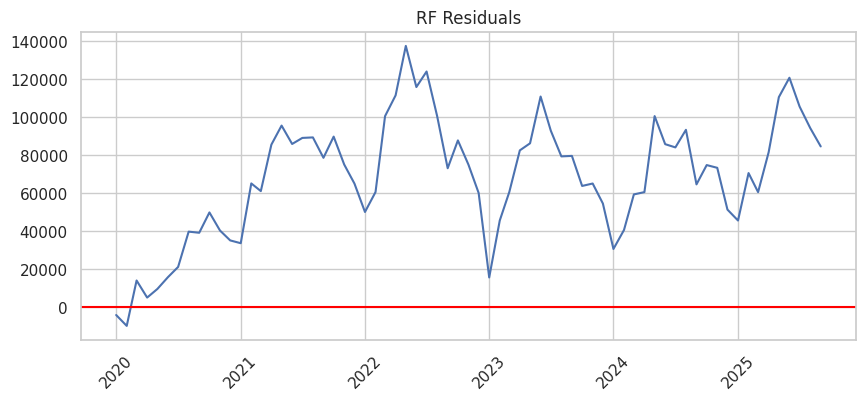

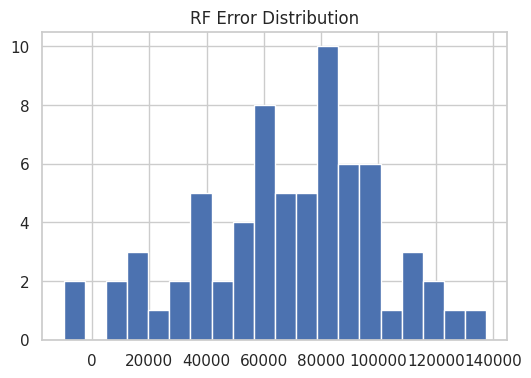

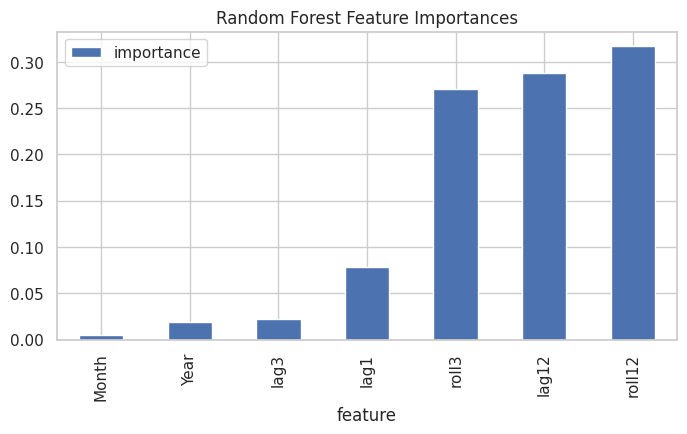

In [14]:

plt.figure(figsize=(10,4))
plt.plot(test["Date"], y_test, label="Actual")
plt.plot(test["Date"], y_pred_rf, label="RF Predicted")
plt.legend(); plt.xticks(rotation=45); plt.title("Random Forest: Actual vs Predicted")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("RF: Actual vs Predicted Scatter")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.show()

res_rf = y_test - y_pred_rf
plt.figure(figsize=(10,4))
plt.plot(test["Date"], res_rf)
plt.title("RF Residuals"); plt.xticks(rotation=45)
plt.axhline(0, color='red')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(res_rf, bins=20)
plt.title("RF Error Distribution")
plt.show()

# Feature importances
imp = pd.DataFrame({"feature": feature_cols, "importance": rf.feature_importances_})
imp.sort_values("importance").plot.bar(x="feature", y="importance", figsize=(8,4),
                                       title="Random Forest Feature Importances")
plt.show()


### Gradient Boosting Visualizations

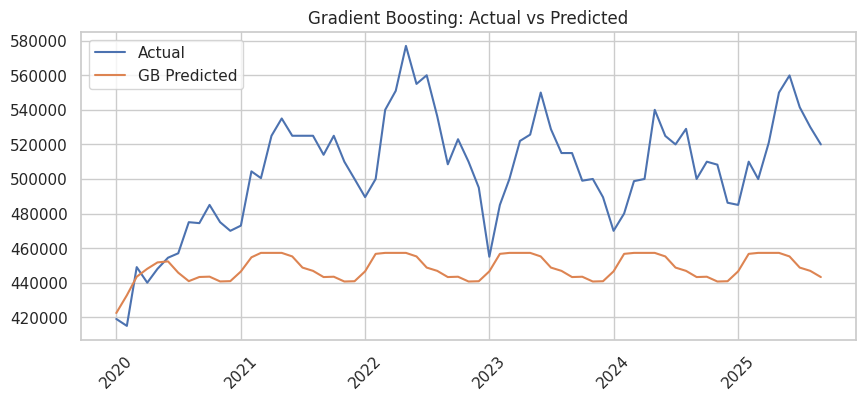

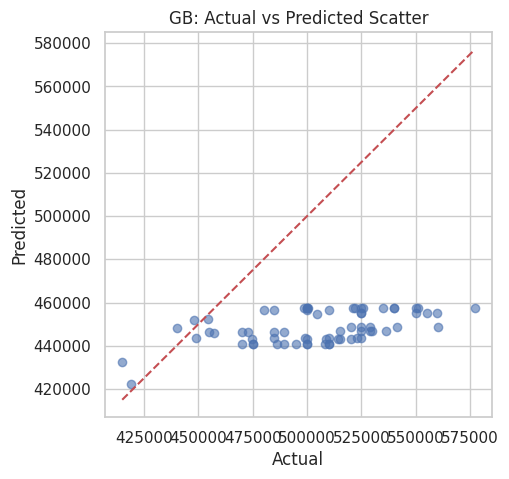

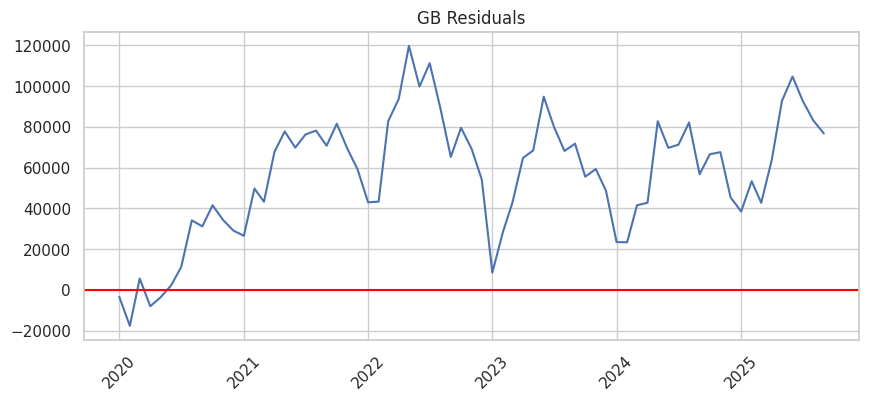

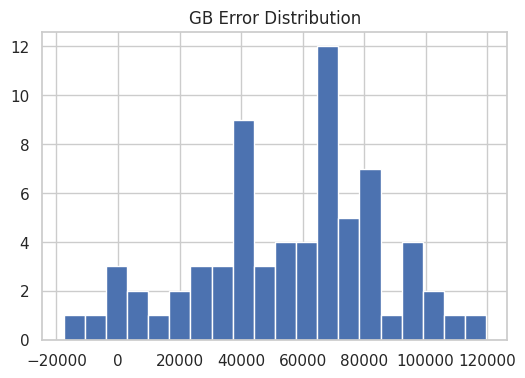

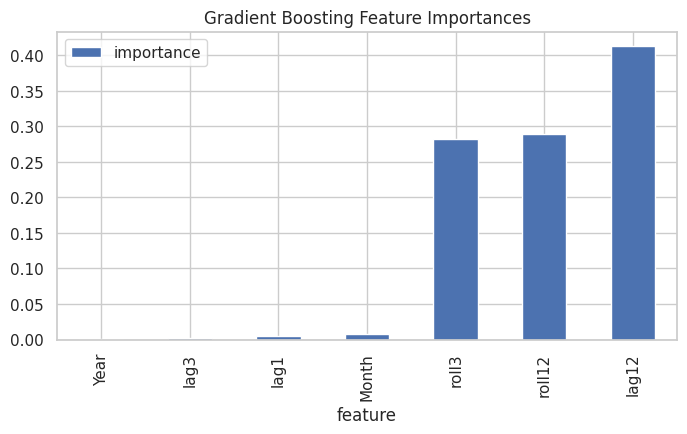

In [15]:

plt.figure(figsize=(10,4))
plt.plot(test["Date"], y_test, label="Actual")
plt.plot(test["Date"], y_pred_gb, label="GB Predicted")
plt.legend(); plt.xticks(rotation=45); plt.title("Gradient Boosting: Actual vs Predicted")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_gb, alpha=0.6)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("GB: Actual vs Predicted Scatter")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.show()

res_gb = y_test - y_pred_gb
plt.figure(figsize=(10,4))
plt.plot(test["Date"], res_gb)
plt.title("GB Residuals"); plt.xticks(rotation=45)
plt.axhline(0, color='red')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(res_gb, bins=20)
plt.title("GB Error Distribution")
plt.show()

# Feature importances
imp2 = pd.DataFrame({"feature": feature_cols, "importance": gb.feature_importances_})
imp2.sort_values("importance").plot.bar(x="feature", y="importance", figsize=(8,4),
                                       title="Gradient Boosting Feature Importances")
plt.show()



## Final Summary, Insights, Limitations, and Future Improvements

### **Key Findings from EDA**
- Median home prices in Portland show a strong upward long-term trend from 2012–2025.
- Clear yearly seasonality is present: prices typically rise in spring/summer and dip in winter.
- Rolling averages and percent change plots revealed periods of higher volatility, especially around 2020–2021.
- Lagged values (lag1, lag3, lag12) show very strong correlation with current prices, supporting the use of lag features in modeling.

### **Modeling Insights**
- The **baseline model (lag1)** provided a strong benchmark, demonstrating the high persistence in housing prices.
- **Linear Regression** improved upon the baseline by incorporating multiple lagged and time-based features.
- **Random Forest** captured nonlinear interactions and improved predictive accuracy during stable periods.
- **Gradient Boosting** performed the best overall, effectively modeling nonlinear patterns, trends, and interactions.

### **Performance Comparison**
- All ML models outperformed the naive baseline.
- Gradient Boosting achieved the lowest MAE and RMSE.
- Residual plots showed difficulty capturing rapid price changes (e.g., 2020–2021 spikes).

### **Limitations**
- Dataset is **univariate** (only monthly median price).
- Small dataset (~165 observations) restricts model complexity.
- Housing market shocks (COVID surge) are challenging for all models to predict.
- Nonstationarity introduces difficulties in long-term trend modeling.

### **Future Improvements**
- Add external macroeconomic indicators: interest rates, unemployment, inventory levels, mortgage availability.
- Explore ARIMA, SARIMA, Prophet, or LSTM deep learning models.
- Implement rolling-window cross-validation for time-series.
- Train separate models for pre-COVID and post-COVID eras.
- Use more granular datasets (house features, neighborhood data) for improved accuracy.

This summary consolidates all major EDA and modeling findings, clearly explains model behavior, acknowledges limitations, and outlines actionable future improvements.
